# Variational Autoencoders

The autoencoder is an extremely useful type of neural network due to its ability to learn important lower-dimensional representations of data. Its bottleneck architecture has been modified to create several other interesting types of networks for various problems, such as sparse autoencoders and denoising autoencoders. One of the most interesting variations is the variational autoencoder - an architecture designed for generative modeling. As autoencoders map their inputs onto a lower-dimensional latent space, Diederik Kingma and Max Welling had the idea to use this latent space and the decoder network to generate new samples. A traditional autoencoder maps its input onto a fixed vector of real numbers, so sampling from this latent space is unlikely to produce any meaningful content as this space is not regularized for generative processes. The defining feature of a variational autoencoder is that its input is mapped onto a distribution. When this latent distribution is properly regularized, the decoder network can take samples from it to produce novel examples. In this project, these examples will be the handwritten digits from the MNIST dataset.

## Importing Packages and Preprocessing Data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train, x_val = x_train / 255.0, x_val / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_val = np.reshape(x_val, (-1, 28, 28, 1))
print(x_train.shape, x_val.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## General Architecture

Given an input $x$ and its latent representation $z$, the VAE is trained to map $x$ onto the latent distribution $P(z|x)$, from which a sample is taken and used to reconstruct the input by sampling from the distribution $P(x|z)$.

In a VAE, the bottleneck vector is replaced by two vectors - a mean vector and standard deviation vector representing the parameters of *P(z|x)*. The encoder takes an input *x*, maps it to these two vectors, and then outputs a sample from this latent distribution *z ~ P(z|x)*, which is then fed into the decoder. Given this sampled latent variable *z*, the decoder is trained to map *z* to back to *x*. Thus the encoder and decoder can be defined as *P(z|x)* and *P(x|z)* respectively.

### Sampling

Below is a function that samples from the latent distribution $P(z|x)$ to be used in generating the encoder's output. It's important to mention that if this network were to randomly from the mean and standard deviation vectors of the latent distribution, it would be impossible to perform backpropagation through this random layer. This function instead uses a reparameterization trick:

$$z = \mu + \epsilon(e^{\sigma/2})$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of the latent variable $z$, and $\epsilon$ represents random noise from a standard normal distribution. This way, a random sample of $z$ is produced, but the only stochastic variable is $\epsilon$, so backpropagation can be ran through $\mu$ and $\sigma$.

In [ ]:
from keras import backend as K

def sample(mu, sigma):
    epsilon = K.random_normal(shape=(K.shape(mu)))
    return mu + K.exp(0.5 * sigma) * epsilon

### Encoder
 

In [ ]:
latent_dim = 12

encoder_input = tf.keras.layers.Input(shape=(28, 28, 1),)

hidden = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=2)(hidden)
shape = K.int_shape(encoder_output)

hidden2 = tf.keras.layers.Flatten()(encoder_output)
hidden2 = tf.keras.layers.Dense(16, activation='relu')(hidden2)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(hidden2)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(hidden2)
z = sample(z_mean, z_log_var)

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 32)     4640        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1568)         0           ['conv2d_1[0][0]']               
                                                                                            

### Decoder

In [ ]:
decoder_input = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
hidden = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(decoder_input)
hidden = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(hidden)

hidden = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3,activation='relu', padding='same', strides=2)(hidden)
hidden = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,activation='relu', padding='same', strides=2)(hidden)
decoder_output = tf.keras.layers.Conv2DTranspose(1, kernel_size=3, activation='relu', padding='same')(hidden)

decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 12)]              0         
                                                                 
 dense_1 (Dense)             (None, 1568)              20384     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       4624      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       4640      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Construct the Variational Autoencoder

After defining the encoder and decoder, we can construct the VAE by simply combining the two models:

In [ ]:
vae_output = decoder(encoder(encoder_input)[2])
vae = tf.keras.Model(encoder_input, vae_output, name='vae')

## Deriving the Loss Function - Variational Inference

We can assume that $P(z)$ follows a standard normal distribution and that $P(x|z)$ follows a normal distribution. Since we're sampling $x$ from $z$, we can describe the mean of $P(x|z)$ as a function of $z$:

$$ P(z) \sim \mathcal{N}(0, I) $$

$$P(x|z) \sim \mathcal{N}(f(z),cI)$$

$I$ in the above definitions represent the identity matrix, used to describe the distributions' covariances. The only remaining distribution of interest is the distribution given by the encoder, $P(z|x)$. However, $P(z|x)$ is often an intractable computation, so instead the VAE has to approximate it somehow. VAEs get their name from variational inference, the technique used to approximate this unknown distribution. The technique involves defining a family of distributions used to approximate this distribution. Once defined, the approximation is made by minimizing an error function that makes the approximated distribution as similar as possible to the target distribution.

In practice, $P(z|x)$ is approximated by a normal distribution $Q_x(z)$, whose mean and covariance are represented by the functions $g(x)$ and $h(x)$:

$$ Q_x(z) \sim \mathcal{N}(g(x),h(x)) $$

Now, the objective is to minimize the a measure of distance between $Q_x(z)$ and $P(z|x)$. In most cases of variational inference, this measure is the Kullback-Leibler Divergence, which is defined as:

$$ D_{KL}(Q||P) = \int P(x)*\log \left (\frac{Q(x)}{P(x)} \right ) dx$$

Given $Q_x(z)$ and $P(z|x)$, we have the following derivation:

$$ D_{KL}\left (Q_x(z) || P(z|x) \right ) = \int Q_x(z)*\log \frac{Q_x(z)}{P(z|x)} dz$$

$$ = \int Q_x(z)*\log \frac{Q_x(z)P(x)}{P(z,x)} dz $$

$$ = \int Q_x(z)* \left (\log P(x) + \log (\frac{Q_x(z)}{P(z,x)} \right ) dz $$

$$ = \log P(x) + \int Q_x(z)*\log \frac{Q_x(z)}{P(z,x)}dz $$

$$ = \log P(x)+ \int Q_x(z)*\log \frac{Q_x(z)}{P(x|z)P(z))} dz $$

$$ = \log P(x) - E_{z\sim Q_x(z)}\left (\log P(x|z)\right ) + \int Q_x(z)*\log \frac{Q_x(z)}{P(z))} $$

$$ = \log P(x) - E_{z\sim Q_x(z)}\left (\log P(x|z)\right ) + D_{KL}\left ( Q_x(z)||P(z)\right )$$

Since we defined $P(x|z) \sim \mathcal{N}(f(z),cI)$, we can replace $\log P(x|z)$ with $-\frac{||x-f(z)||^2}{2c}$. We're trying to minimize this function with respect to $f(z)$, the mean of $P(x|z)$, and $g(x)$ and $h(x)$, the parameters of $Q_x(z)$. $\log P(x)$ is fixed, so we can ignore that term - our function to minimize is then

$$ D_{KL}\left (Q_x(z) || P(z|x) \right ) = E_{z\sim Q_x(z)}\left ( \frac{||x-f(z)||^2}{2c}\right ) + D_{KL}\left ( Q_x(z)||P(z)\right )$$

Interestingly, we can identify the first term on the right hand side as a form of the reconstruction cost. This term is minimized when the mean of $P(x|z)$, $f(z)$ is equal to $x$ - in other words, the decoder recreates the inputs $x$ most accurately when the average output of its sampling process is equivalent to the input itself. The second term is the KL Divergence between our approximation of our encoder's distribution, $P(z|x)$ and the standard normal latent space distribution $P(z)$. This can be thought of as the regularization term of the function which ensures that the distribution of our encoder's output is similar to the standard normal. This is important because when minimizing only the reconstruction cost, the VAE can overfit and learn like a traditional autoencoder - variances can be very small and means can vary significantly. Due to these issues sampling from the latent space distribution is not guaranteed to produce a meaningful output. Regularizing the encoder's distribution to be close to the standard normal ensures that means are all centered around 0 and standard deviations close to 1. This ensures a relatively smooth, complete, and continuous latent space where points are not too separated and nearby points have similar outputs.

## Defining the Loss Function

In practice, the reconstruction cost of a VAE is expressed using either mean squared error or binary cross-entropy. In this case, we'll use binary cross-entropy:

In [ ]:
reconstruction_cost = tf.keras.losses.binary_crossentropy(K.flatten(encoder_input), K.flatten(vae_output))
reconstruction_cost *= 784

For the regularization term, there is a closed-form of the Kullback-Leibler Divergence that is a function of only our distribution's mean and variance:

$$D_{KL}\left (Q_x(z) || \mathcal{N}(0,1) \right ) = \frac{1}{2}\sum \left (1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)$$

In [ ]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

After defining the loss function, we add it to our model and compile the VAE:


In [ ]:
loss = K.mean(reconstruction_cost + kl_loss)

vae.add_loss(loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 12),         30312       ['input_1[0][0]']                
                                 (None, 12),                                                      
                                 (None, 12)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    29937       ['encoder[0][2]']                
                                                                                                

## Model Training

In [ ]:
vae.fit(x_train, epochs = 15, batch_size = 128, shuffle = True, validation_data = (x_val,None))

Epoch 1/15
469/469 [==============================] - 62s 129ms/step - loss: 204.1629 - val_loss: 154.8271
Epoch 2/15
469/469 [==============================] - 61s 131ms/step - loss: 152.0452 - val_loss: 142.1706
Epoch 3/15
469/469 [==============================] - 59s 127ms/step - loss: 145.3740 - val_loss: 139.0027
Epoch 4/15
469/469 [==============================] - 60s 127ms/step - loss: 143.1444 - val_loss: 139.6306
Epoch 5/15
469/469 [==============================] - 59s 126ms/step - loss: 149.2629 - val_loss: 147.1347
Epoch 6/15
469/469 [==============================] - 60s 127ms/step - loss: 138.9909 - val_loss: 134.4212
Epoch 7/15
469/469 [==============================] - 59s 126ms/step - loss: 146.2814 - val_loss: 139.5435
Epoch 8/15
469/469 [==============================] - 59s 125ms/step - loss: 140.5928 - val_loss: 134.8914
Epoch 9/15
469/469 [==============================] - 59s 125ms/step - loss: 134.2273 - val_loss: 140.6591
Epoch 10/15
469/469 [================

## Image Generation

After training the VAE, we can use the decoder to replicate the handwriten digits of the MNIST dataset:

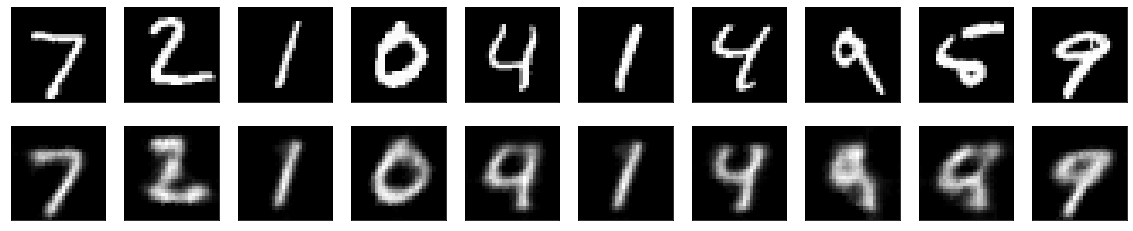

In [ ]:
z_mean, _, _ = encoder.predict(x_val)
decoded_imgs = decoder.predict(z_mean)

n = 10
plt.figure(figsize=(20, 4))
for i in range(10):
	plt.gray()
	ax = plt.subplot(2, n, i+1)
	plt.imshow(x_val[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
	
	ax = plt.subplot(2, n, i +1+n)
	plt.imshow(decoded_imgs[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
plt.show()

## Conclusion

With a 12-dimensional latent space, the generated images are somewhat blurry, but are decently recognizable. Well-designed variational autoencoders can produce highly impressive results across a wide variety of inputs, which serve as an inspiration for the potential of deep generative modeling. Another important and very interesting generative framework is the Generative Adversarial Network introduced by Ian Goodfellow in 2014, which overcomes many of the shortcomings of VAEs and can generate images virtually indistinguishable from real examples. From image generation to data augmentation, this field has some of the most exciting applications in all of machine learning and is bound to produce spectacular findings in the near future.